# Exporting PyTorch Models

Some short intro code.

- [ExecuTorch Runtime Overview](https://pytorch.org/executorch/stable/runtime-overview.html)
- [Deploying Torch-TensorRT Programs](https://pytorch.org/TensorRT/tutorials/runtime.html)
- [`torch.onnx`](https://pytorch.org/docs/stable/onnx.html)
- [TorchDynamo-based ONNX Exporter](https://pytorch.org/docs/stable/onnx_dynamo.html#torchdynamo-based-onnx-exporter)
  - this one might be more difficult to make work
- [TorchScript-based ONNX Exporter](https://pytorch.org/docs/stable/onnx_torchscript.html)
  - this is what i used to export the model here

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import cv2

import torch
import deeplabcut as dlc

from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict, pretty_print
from deeplabcut.pose_estimation_pytorch.models import PoseModel

Loading DLC 3.0.0rc4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# root = Path("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train")
# model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
# weights_path = root / "snapshot-200.pt"
# #dest_dict = Path("/media1/data/anna/DLC_AI2024/DeepLabCut-live/ONNX_files")

root = Path("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy")
model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
weights_path = root / "snapshot-200.pt"
#dest_dict = Path("/media1/data/anna/DLC_AI2024/DeepLabCut-live/ONNX_files")


pretty_print(model_cfg["model"])

backbone:
  type: ResNet
  model_name: resnet50_gn
  output_stride: 16
  freeze_bn_stats: True
  freeze_bn_weights: False
backbone_output_channels: 2048
heads:
  bodypart:
    type: HeatmapHead
    weight_init: normal
    predictor:
      type: HeatmapPredictor
      apply_sigmoid: False
      clip_scores: True
      location_refinement: True
      locref_std: 7.2801
    target_generator:
      type: HeatmapGaussianGenerator
      num_heatmaps: 25
      pos_dist_thresh: 17
      heatmap_mode: KEYPOINT
      generate_locref: True
      locref_std: 7.2801
    criterion:
      heatmap:
        type: WeightedMSECriterion
        weight: 1.0
      locref:
        type: WeightedHuberCriterion
        weight: 0.05
    heatmap_config:
      channels: [2048, 25]
      kernel_size: [3]
      strides: [2]
    locref_config:
      channels: [2048, 50]
      kernel_size: [3]
      strides: [2]


In [4]:
model = PoseModel.build(model_cfg["model"])
weights = torch.load(weights_path, map_location="cuda", weights_only=False)
model.load_state_dict(weights['model'])

<All keys matched successfully>

In [5]:
#!pip install --upgrade onnx onnxscript


In [5]:
img = cv2.imread("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/img003.png")
img = torch.Tensor(img).permute(2,0,1)
img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
model.eval()
outputs = model(img)
predictions = model.get_predictions(outputs)

print(predictions)

{'bodypart': {'poses': tensor([[[[4.6099e+02, 3.0565e+02, 2.2497e-01],
          [4.6334e+02, 2.9737e+02, 5.2393e-01],
          [4.7105e+02, 2.9226e+02, 5.7827e-01],
          [4.7816e+02, 2.9004e+02, 6.5970e-01],
          [5.7700e+02, 3.4287e+02, 6.7695e-01],
          [4.4610e+02, 3.3317e+02, 6.4596e-01],
          [5.3632e+02, 4.2195e+02, 5.4373e-01],
          [4.5563e+02, 3.5570e+02, 2.5123e-01],
          [5.5438e+02, 3.6476e+02, 6.2622e-01],
          [5.3584e+02, 3.6377e+02, 6.4735e-01],
          [5.1307e+02, 3.6640e+02, 6.0587e-01],
          [5.2159e+02, 2.9548e+02, 4.5409e-01],
          [4.8214e+02, 3.8471e+02, 2.4118e-01],
          [4.8334e+02, 2.1336e+02, 7.4011e-01],
          [4.5919e+02, 2.0870e+02, 6.2153e-01],
          [6.0561e+02, 4.7224e+02, 5.8598e-01],
          [5.9742e+02, 4.2868e+02, 4.8355e-01],
          [5.7910e+02, 4.2470e+02, 2.6089e-01],
          [4.6775e+02, 4.9880e+02, 8.5475e-01],
          [4.4069e+02, 4.2392e+02, 6.7025e-01],
          [4.3888

In [6]:
model.state_dict()

OrderedDict([('backbone.model.conv1.weight',
              tensor([[[[ 6.2382e-04,  3.2888e-03,  4.5522e-03,  ...,  1.0268e-04,
                         -3.6941e-03, -1.8642e-03],
                        [ 6.1345e-04,  5.2515e-03,  1.3456e-04,  ..., -5.4560e-03,
                         -1.2183e-03, -1.2726e-03],
                        [ 3.8172e-03,  4.4303e-03,  1.0692e-03,  ..., -1.0856e-02,
                          4.5952e-03,  4.5998e-03],
                        ...,
                        [ 3.1927e-04, -3.7794e-03, -1.8911e-02,  ...,  4.5275e-03,
                          1.3478e-02,  7.8987e-03],
                        [-4.5656e-03, -4.5899e-03, -1.0469e-02,  ..., -1.5723e-03,
                          3.8851e-03,  6.7099e-04],
                        [-3.8119e-03, -7.7898e-03, -5.0725e-03,  ...,  2.6294e-03,
                          7.5247e-03,  3.1249e-03]],
              
                       [[ 9.9969e-03, -2.0495e-04,  5.4443e-03,  ..., -4.1187e-03,
                 

In [9]:
dummy_input = torch.zeros((1, 3, 640, 480))

torch.onnx.export(
    model,
    img,
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/resnet.onnx",
    verbose=False,
    input_names = ['input'],
    dynamic_axes={'input' : {0 : 'batch_size',
                             2 : 'height',
                             3 : 'width'}}
)

In [10]:
import onnx

# Load the ONNX model
onnx_model = onnx.load("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/resnet.onnx")

# Check that the model is well formed
onnx.checker.check_model(onnx_model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

graph main_graph (
  %input[FLOAT, batch_sizex3xheightxwidth]
) initializers (
  %backbone.model.conv1.weight[FLOAT, 64x3x7x7]
  %backbone.model.layer1.0.conv1.weight[FLOAT, 64x64x1x1]
  %backbone.model.layer1.0.conv2.weight[FLOAT, 64x64x3x3]
  %backbone.model.layer1.0.conv3.weight[FLOAT, 256x64x1x1]
  %backbone.model.layer1.0.downsample.0.weight[FLOAT, 256x64x1x1]
  %backbone.model.layer1.1.conv1.weight[FLOAT, 64x256x1x1]
  %backbone.model.layer1.1.conv2.weight[FLOAT, 64x64x3x3]
  %backbone.model.layer1.1.conv3.weight[FLOAT, 256x64x1x1]
  %backbone.model.layer1.2.conv1.weight[FLOAT, 64x256x1x1]
  %backbone.model.layer1.2.conv2.weight[FLOAT, 64x64x3x3]
  %backbone.model.layer1.2.conv3.weight[FLOAT, 256x64x1x1]
  %backbone.model.layer2.0.conv1.weight[FLOAT, 128x256x1x1]
  %backbone.model.layer2.0.conv2.weight[FLOAT, 128x128x3x3]
  %backbone.model.layer2.0.conv3.weight[FLOAT, 512x128x1x1]
  %backbone.model.layer2.0.downsample.0.weight[FLOAT, 512x256x1x1]
  %backbone.model.layer2.1.conv1.

In [ ]:
#pip install onnxruntime

In [54]:
import onnxruntime as ort
import numpy as np
from dlclive.pose import argmax_pose_predict, extract_cnn_output, multi_pose_predict


img_np = img.detach().numpy()
print(img_np.dtype, img_np.shape)

ort_session = ort.InferenceSession("/media1/data/dikra/fly-kevin/resnet.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: img_np}
outputs = ort_session.run(
    None,
    ort_inputs,
)

float32 (1, 3, 540, 682)


In [56]:
outputs[0].shape, outputs[1].shape

((1, 25, 69, 87), (1, 50, 69, 87))

In [55]:
from dlclive import DLCLive, Processor
import dlclive
from dlclive.display import Display
import cv2
import numpy as np 
from dlclive.pose import argmax_pose_predict
from dlclive.predictor import HeatmapPredictor

In [112]:
dlc_proc = Processor()
#Dikra
dlc_live = DLCLive(pytorch_cfg="/media1/data/dikra/fly-kevin", processor=dlc_proc, snapshot='/media1/data/dikra/fly-kevin/snapshot-100.pt', model_type='pytorch')
img = cv2.imread("/media1/data/dikra/fly-kevin/img001.png")

In [113]:
outputs_dict = dict()
outputs_dict['heatmap'] = torch.Tensor(outputs[0])
outputs_dict['locref'] = torch.Tensor(outputs[1])

In [ ]:
pred = 

In [114]:
pred = HeatmapPredictor()
pose = pred(stride=float(16), outputs=outputs_dict)

16.0
torch.Size([1, 25, 69, 87])
torch.Size([1, 69, 87, 25])
torch.Size([1, 50, 69, 87])
torch.Size([1, 69, 87, 25, 2])
dz torch.Size([1, 1, 25, 3])
tensor([[[53, 36, 41, 41, 41, 39, 26, 38, 30, 28, 26, 34, 32, 46, 46, 24, 42,
          49, 19, 21, 28, 33, 38, 24, 38]]]) tensor([[[18,  8, 16, 16, 14, 17, 10,  8, 15, 17, 17, 20, 16, 17, 18,  3,  3,
           3,  3,  4,  4, 13, 15, 12, 17]]])
tensor([[[854.6654, 592.8895, 671.5017, 667.5016, 661.4243, 633.4468, 425.4671,
          615.9876, 494.4840, 456.9178, 423.3133, 551.7769, 524.7359, 750.8708,
          737.2157, 395.4978, 684.3283, 791.5762, 313.8143, 341.5430, 457.0668,
          530.3159, 616.5417, 387.1540, 612.7570]]]) tensor([[[298.6238, 138.3950, 252.4909, 252.2753, 230.4766, 274.3203, 164.2581,
          124.4953, 245.6091, 277.2044, 283.1867, 324.5868, 266.5107, 281.7554,
          297.3348,  54.8089,  55.8737,  59.7722,  53.2049,  66.5433,  73.2418,
          209.7249, 241.5219, 200.4657, 279.8684]]])
tensor([[[[  2.6238

In [115]:
pose = pose['poses'].detach().numpy()

In [116]:
pose = pose.squeeze()
pose.shape

(25, 3)

In [117]:
pose[:,0], pose[:,1]

(array([298.6238 , 138.39503, 252.49094, 252.27533, 230.47664, 274.32028,
        164.25807, 124.49529, 245.60907, 277.20444, 283.1867 , 324.58676,
        266.51068, 281.75543, 297.33478,  54.80887,  55.87374,  59.77223,
         53.20493,  66.54332,  73.24177, 209.72488, 241.52194, 200.46565,
        279.8684 ], dtype=float32),
 array([854.6654 , 592.88947, 671.5017 , 667.50165, 661.42426, 633.4468 ,
        425.46707, 615.9876 , 494.484  , 456.91776, 423.31332, 551.7769 ,
        524.7359 , 750.8708 , 737.2157 , 395.4978 , 684.3283 , 791.57623,
        313.8143 , 341.543  , 457.0668 , 530.3159 , 616.5417 , 387.154  ,
        612.757  ], dtype=float32))

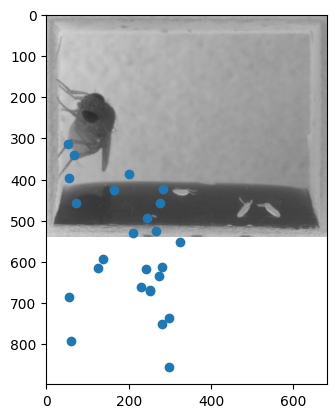

In [118]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.scatter(pose[:,0], pose[:,1])

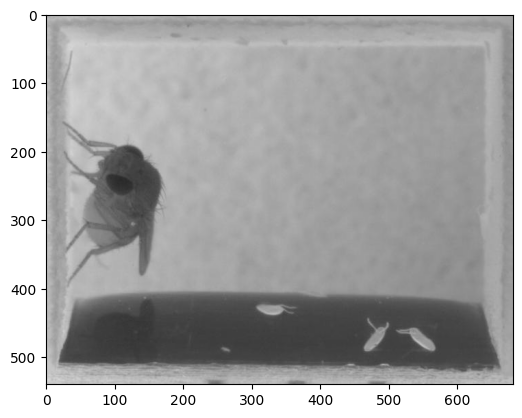

In [88]:
plt.imshow(img)